In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as pd
from pygem_eb.processing.plotting_fxns import *
from objectives import *
data_fp = '/home/claire/research/MB_data/Gulkana/Input_Gulkana_Glaciological_Data.csv'

In [14]:
# FIND BEST RUN IN A SET
date = '10_08'
path_out = f'/home/claire/research/Output/calibration/{date}_AWS/'
sites= ['AB','B','D']
# fn = f'kw{kw}_ksnow{k_snow}_aice{a_ice}_site{site}_0.nc'
dsdict = {'AB':[],'B':[],'D':[]}
outdict = {'AB':[],'B':[],'D':[]}
for i in range(225):
    fn = f'calibration_{date}_run{i}_0.nc'
    try:
        ds,startdate,enddate = getds(path_out+fn)
    except:
        print(fn,'doesnt exist')
        continue
    site = ds.attrs['site']
    winter,summer = seasonal_mass_balance(data_fp,ds,site)
    dsdict[site].append(ds)
    # if i % 5 == 0:
    #     print(ds.attrs[param])
    # outdict[site].append(np.mean([winter,summer]))
    outdict[site].append(winter)
    # print(ds.attrs['k_snow'],winter,summer,np.mean([winter,summer]))
best = {}
for site in sites:
    best[site] = dsdict[site][np.argmin(outdict[site])]
    print(site,np.argmin(outdict[site]))
    # simple_plot(ds,['2004-04-20','2004-10-20'],[['albedo']],res='d')

calibration_10_08_run211_0.nc doesnt exist
AB 64
B 14
D 19


In [23]:
result_df = pd.DataFrame(data=np.zeros((len(sites),3)),columns=sites,index=['kp','kw','a_ice'])
for site in sites:
    ds = best[site]
    result_df.loc['kp',site] = float(ds.attrs['kp'])
    if site == 'D':
        result_df.loc['kw',site] = 2 #float(ds.attrs['kw'])
        result_df.loc['a_ice',site] = 0.4
    else:
        result_df.loc['a_ice',site] = float(ds.attrs['a_ice'])
        result_df.loc['kw',site] = 3
result_df.to_csv(f'/home/claire/research/Gulkana_params_{date}_HIGHWIND.csv',sep=',')
print(result_df)

           AB     B    D
kp     2.6875  2.75  3.0
kw     1.0000  1.00  0.7
a_ice  0.2000  0.40  0.4


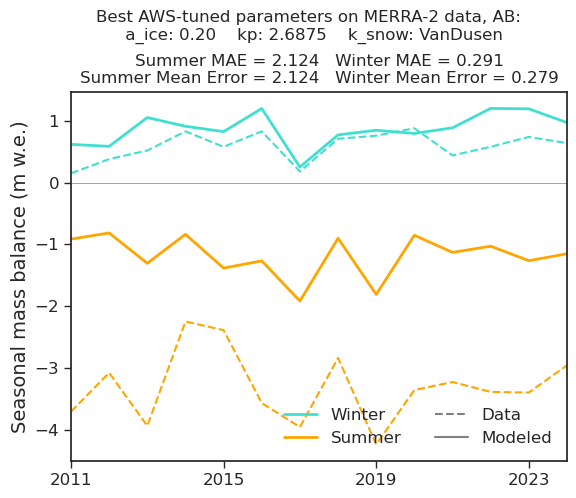

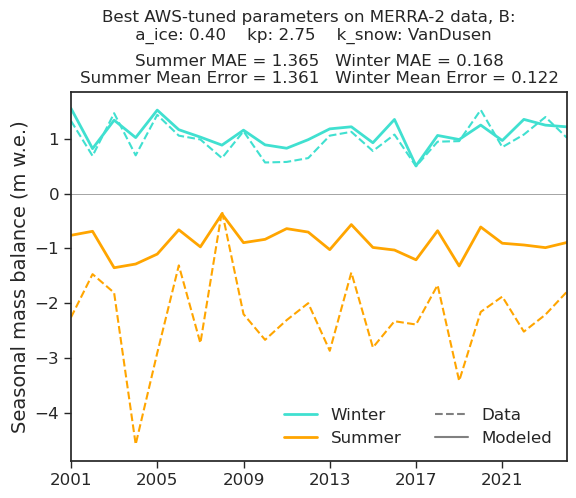

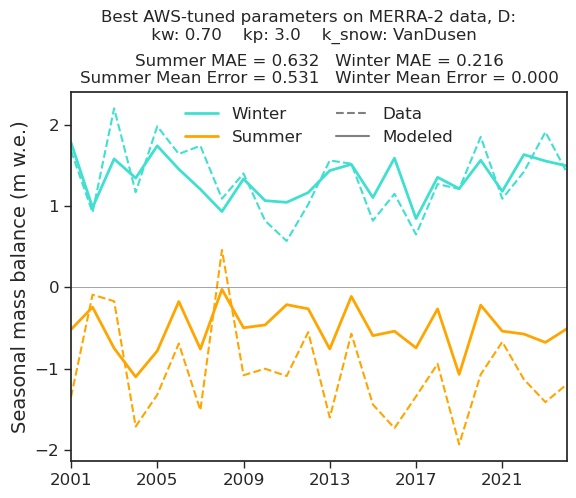

In [27]:
for site in sites:
    # ds = best[site]
    ds = xr.open_dataset(f'/home/claire/research/Output/EB/Gulkana_10_09_paramset_{site}_0.nc')
    param = 'kw' if site == 'D' else 'a_ice'
    k_snow = 'VanDusen' # ds.attrs['k_snow']
    # kw = ds.attrs['kw']
    # a_ice = ds.attrs['a_ice']
    # kp = ds.attrs['kp']
    kp = result_df.loc['kp',site]
    kw = result_df.loc['kw',site]
    a_ice = result_df.loc['a_ice',site]
    param_value = kw if param == 'kw' else a_ice # float(ds.attrs[param])
    fig,ax = seasonal_mass_balance(data_fp,ds,site,plot=True)
    fig.suptitle(f'Best AWS-tuned parameters on MERRA-2 data, {site}: \n {param}: {param_value:.2f}    kp: {kp}    k_snow: {k_snow}',y=1.05)
    plt.savefig(f'/home/claire/research/Output/calibration/{date}_paramsMERRA2_{site}.png',dpi=200,bbox_inches='tight')

In [11]:
var = 'wind'
ds_AWS = xr.open_dataset('/home/claire/research/Output/EB/Gulkana_2024_10_08_1_climate.nc')
ds_MERRA2 = xr.open_dataset('/home/claire/research/Output/EB/Gulkana_2024_10_08_0_climate.nc')
ds3 =  xr.open_dataset('/home/claire/research/Output/EB/Gulkana_2024_10_08_climate.nc')
# ds4 = ds3['temp'] *m+b
ds_AWS = ds_AWS[var].resample(time='MS').mean()
ds_MERRA2 = ds_MERRA2[var].resample(time='MS').mean()
ds3 = ds3[var].resample(time='MS').mean()
# ds4 = ds4.resample(time='MS').mean()

fig,axes = plt.subplots(1,2,figsize=(8,2.5),width_ratios=(2,1),gridspec_kw={'wspace':0.35})
axes[1].scatter(ds_AWS.values,ds3.values,color='red')
axes[1].set_ylabel('MERRA-2',fontsize=12)
axes[1].set_xlabel('AWS',fontsize=12)
valmin = np.min([ds_AWS.values,ds3.values])
# valmax = np.max([ds_AWS.values,ds3.values])
valmax = 7
axes[1].plot([valmin,valmax],[valmin,valmax],'k--')
axes[1].set_ylim(valmin,valmax)
axes[1].set_xlim(valmin,valmax)

# axes[2].scatter(ds_AWS.values,ds_MERRA2.values,label='MERRA-2',color='red')
# axes[2].set_ylabel('MERRA-2, Corrected',fontsize=12)
# axes[2].set_xlabel('AWS',fontsize=12)
# valmin = np.min([ds_AWS.values,ds_MERRA2.values])
# valmax = np.max([ds_AWS.values,ds_MERRA2.values])
# axes[2].plot([valmin,valmax],[valmin,valmax],'k--')
axes[1].set_ylim(1,6)
axes[1].set_xlim(1,6)
axes[1].set_xticks(np.arange(1,7))
axes[1].set_yticks(np.arange(1,7))
ax = axes[0]
dtfm = mpl.dates.DateFormatter('%Y')
ax.plot(ds_AWS.time,ds_AWS.values,label='AWS',color=mpl.cm.tab10(1))
ax.plot(ds3.time,ds3.values,label='MERRA-2',color=mpl.cm.tab10(2),linestyle=':')
# ax.plot(ds_MERRA2.time,ds4.values,label='MERRA-2 (corrected)',color=mpl.cm.tab10(0))
ax.set_ylim(1,6)
ax.set_yticks(np.arange(1,7))
ax.set_ylabel('Air temperature ($^{\circ}$C)',fontsize=12)
start = pd.to_datetime('2009-12-31 00:00')
# ax.set_ylabel('Wind speed (m/s)',fontsize=12)
end = pd.to_datetime('2020-01-01')
ax.set_xlim(start,end)
ax.xaxis.set_major_formatter(dtfm)
ax.set_xticks(pd.date_range(start,end,freq='24MS'))
ax.legend(facecolor='white',edgecolor='none',loc='upper left')
for ax in axes:
    ax.tick_params(length=5)
# plt.show()
plt.savefig('/home/claire/research/climate_data/MERRA2_AWS_NEWWIND.png',bbox_inches='tight',dpi=250)

0.7280142198171007 2.2339880865065864


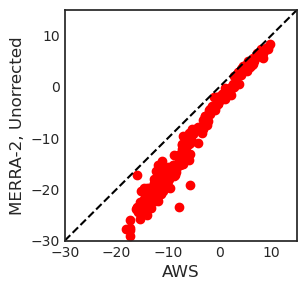

In [4]:
threshold = 15
aws = ds_AWS.values[ds3.values < threshold]
merra = ds3.values[ds3.values < threshold]

# m,_,_,_ = np.linalg.lstsq(merra[:, np.newaxis],aws,rcond=None)
# b = [0]
m,b = np.polyfit(merra,aws,1)
plt.figure(figsize=(3,3))
plt.scatter(ds_AWS.values,ds3.values,color='red')
plt.xlabel('AWS',fontsize=12)
plt.ylabel('MERRA-2, Unorrected',fontsize=12)
# plt.scatter(aws,merra*m+b,color='red')
# plt.scatter(ds_AWS.values[ds3.values >= threshold],ds3.values[ds3.values >= threshold],color='red')
minx = -30
maxx = 20 #np.max(merra)
# plt.plot([minx,maxx],[minx*m[0]+b[0],maxx*m[0]+b[0]],'k')
plt.plot([minx,maxx],[minx,maxx],'k--')
plt.xlim(-30,15)
plt.ylim(-30,15)
# plt.show()
plt.savefig('/home/claire/research/climate_data/uncorrected_temp.png',dpi=200,bbox_inches='tight')
print(m,b)

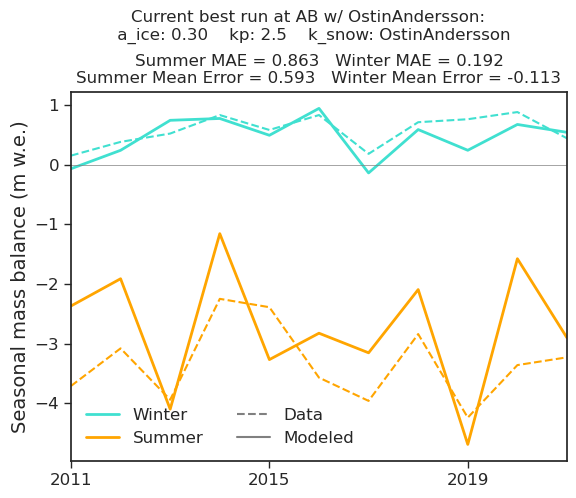

In [45]:
k_snow = ds.attrs['k_snow']
kw = ds.attrs['kw']
a_ice = ds.attrs['a_ice']
kp = ds.attrs['kp']
param_value = float(ds.attrs[param])
fig,ax = seasonal_mass_balance(data_fp,ds,site,plot=True)
fig.suptitle(f'Current best run at {site}: \n {param}: {param_value:.2f}    kp: {kp}    k_snow: {k_snow}',y=1.05)
# plt.show()
# plt.savefig(f'/home/claire/research/Output/calibration/10_05_0/best_{site}.png',dpi=200,bbox_inches='tight')

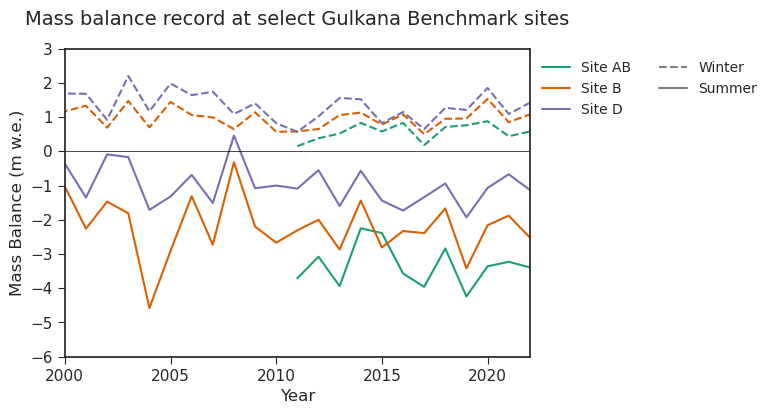

In [42]:
df = pd.read_csv(data_fp)
df['bs'] = df['ba'] - df['bw']
colors = mpl.cm.Dark2
plt.figure(figsize=(6,4))
for i,site in enumerate(['AB','B','D']):
    c = colors(i)
    site_df = df[df['site_name'] == site]
    plt.plot(site_df['Year'],site_df['bw'],linestyle='--',color=c)
    plt.plot(site_df['Year'],site_df['bs'],color=c,label=f'Site {site}')
plt.plot(np.nan,np.nan,linestyle='--',color='gray',label='Winter')
plt.plot(np.nan,np.nan,color='gray',label='Summer')
plt.axhline(0,color='black',linewidth=0.5)
plt.legend(ncols=2,bbox_to_anchor=(1,1))
plt.xlim(2000,2022)
plt.ylim(-6,3)
plt.xticks(np.arange(2000,2023,5))
plt.tick_params(size=5,labelsize=11)
plt.xlabel('Year',fontsize=12)
plt.ylabel('Mass Balance (m w.e.)',fontsize=12)
plt.title('Mass balance record at select Gulkana Benchmark sites',fontsize=14,y=1.05)
plt.savefig('/home/claire/research/MB_data/three_sites_legend.png',dpi=300,bbox_inches='tight')

In [234]:
path_out = '/home/claire/research/Output/calibration/09_24/'

# Parameter sets
aa = [0.2,0.4,0.6]
ww = [0.25,0.5,0.75,1]
kk = ['Sturm','Douville','Jansson'] #,'OstinAndersson','VanDusen']
params_dict = {'kw':ww,'k_snow':kk,'a_ice':aa} # 'kw':ww,

# Get the lengths of each parameter list for the result array shape
shape = [len(v) for v in params_dict.values()]

# Initialize result arrays with a dimension for site (3 sites + 1 for the average)
winter_result = np.ones([4] + shape)
summer_result = np.ones([4] + shape)

# Initialize lists for storing the parameters
params_list = {key: [] for key in params_dict}

# Generate combinations of all parameters
all_combos = itertools.product(*params_dict.values())
for idx, param_values in enumerate(all_combos):
    # Unpack indices
    indices = np.unravel_index(idx, shape)

    # Store parameter set
    for param_name, param_value in zip(params_dict.keys(), param_values):
        params_list[param_name].append(param_value)
    
    # Iterate over sites
    for s, site in enumerate(['AB', 'B', 'D']):
        kw = 0.25 if site == 'D' else 1
        fn = f'kw{kw}_'

        # fn = ''
        for param_name, param_value in zip(params_dict.keys(), param_values):
            fn += param_name.replace('_','')+str(param_value)+'_'
        fn += f'site{site}_0.nc'

        try:
            ds, startdate, enddate = getds(path_out + fn)
            winter, summer = seasonal_mass_balance(data_fp, ds, site=site, method='MAE')
        except:
            winter, summer = (np.nan, np.nan)
            print(fn + ' does not exist')
        
        # Store results in the corresponding array
        winter_result[s][indices] = winter
        summer_result[s][indices] = summer

    # Compute site averages and store in the last index (3rd index in the result arrays)
    winter_result[3][indices] = np.mean(winter_result[:3,*indices])
    summer_result[3][indices] = np.mean(summer_result[:3,*indices])

In [235]:
best = {'winter': {key: [] for key in params_dict}, 
        'summer': {key: [] for key in params_dict}}

if summer_result.shape == (4,4,3,3):
    print('When including kw as a parameter:')
elif summer_result.shape == (4,3,3):
    print('When setting kw = 0.25 at site D, 1 elsewhere:')
for site in ['mean','AB','B','D','mean']:
    idx = np.where(np.array(['AB','B','D','mean']) == site)[0]
    best_winter = np.argmin(winter_result[idx])
    best_summer = np.argmin(summer_result[idx])
    for key in params_dict:
        best['winter'][key] = params_list[key][best_winter]
        best['summer'][key] = params_list[key][best_summer]
    if site == 'mean':
        print('Best winter parameter set overall:',best['winter'])
        print('Best summer parameter set overall:',best['summer'])
        print()
    else:
        print(f'Best winter parameter set at site {site}:',best['winter'])
        print(f'Best summer parameter set at site {site}:',best['summer'])

When setting kw = 0.25 at site D, 1 elsewhere:
Best winter parameter set overall: {'k_snow': 'Sturm', 'a_ice': 0.6}
Best summer parameter set overall: {'k_snow': 'Jansson', 'a_ice': 0.6}

Best winter parameter set at site AB: {'k_snow': 'Jansson', 'a_ice': 0.4}
Best summer parameter set at site AB: {'k_snow': 'Jansson', 'a_ice': 0.2}
Best winter parameter set at site B: {'k_snow': 'Sturm', 'a_ice': 0.6}
Best summer parameter set at site B: {'k_snow': 'Jansson', 'a_ice': 0.6}
Best winter parameter set at site D: {'k_snow': 'Sturm', 'a_ice': 0.6}
Best summer parameter set at site D: {'k_snow': 'Sturm', 'a_ice': 0.2}
Best winter parameter set overall: {'k_snow': 'Sturm', 'a_ice': 0.6}
Best summer parameter set overall: {'k_snow': 'Jansson', 'a_ice': 0.6}



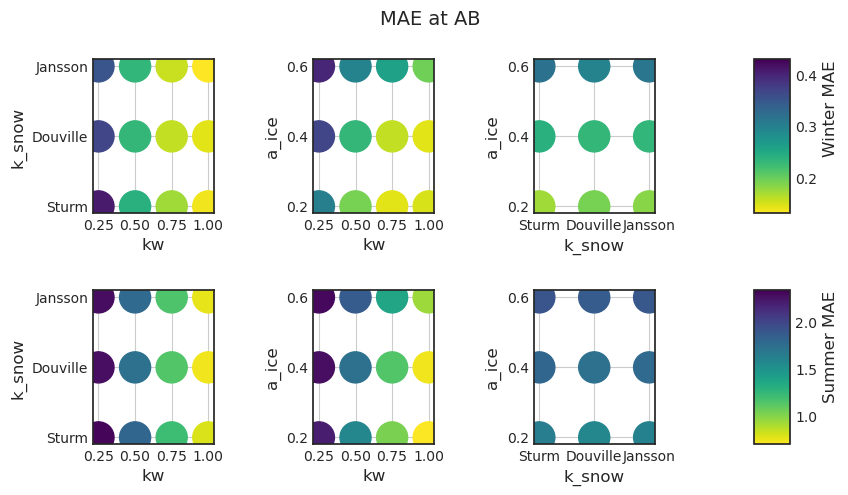

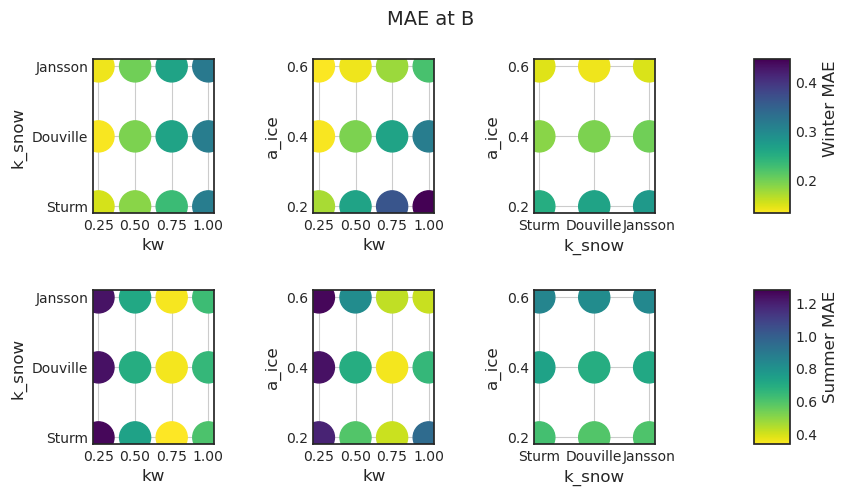

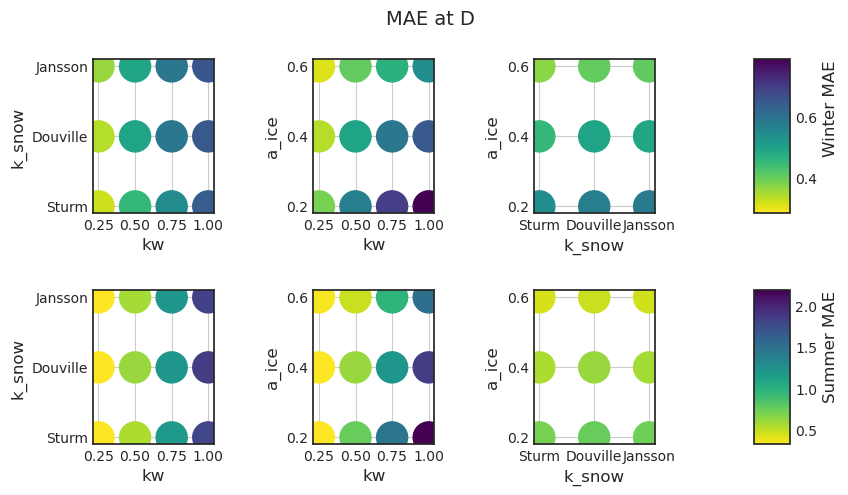

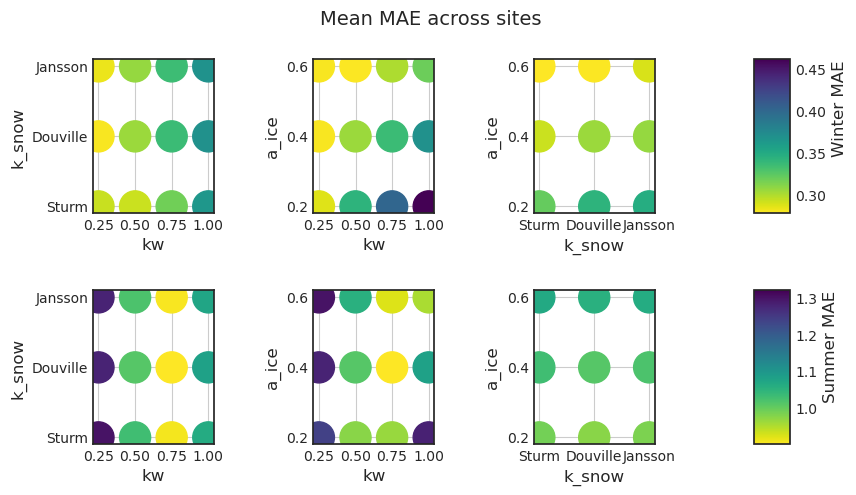

In [243]:
for site in ['AB','B','D','mean']:
    idx = np.where(np.array(['AB','B','D','mean']) == site)[0][0]
    fig, axes = grid_plot(params_dict,summer_result[idx],winter_result[idx])
    if site == 'mean':
        title_first = f'Mean MAE across sites'
    else:
        title_first = f'MAE at {site}'
    if summer_result.shape == (4,4,3,3):
        fig.suptitle(title_first,fontsize=14)
        plt.savefig(f'/home/claire/research/Output/Figs/grid_plot_{site}.png',dpi=200,bbox_inches='tight')
    elif summer_result.shape == (4,3,3):
        fig.suptitle(f'{title_first}\nWith kw=0.25 at D and 1 elsewhere',fontsize=14)
        plt.savefig(f'/home/claire/research/Output/Figs/grid_plot_{site}_nokw.png',dpi=200,bbox_inches='tight')

Must index dates exactly 1 year - 1 day apart
0.8826196077192149


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Summer accumulation and winter ablation at site B'}, ylabel='Partitioned seasonal mass balance (m w.e.)'>)

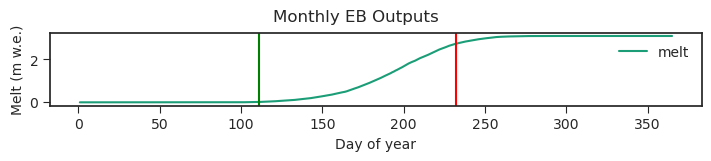

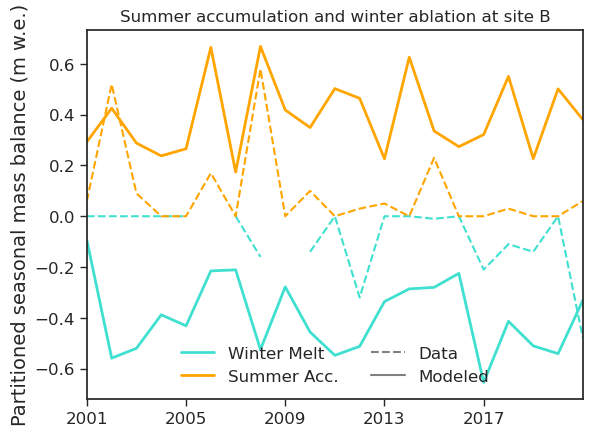

In [16]:
plot_by(ds,[startdate,'2022-04-20'],[['melt']],by='doy')
seasonal_mass_balance(data_fp,ds,'B',plot='w-s+')

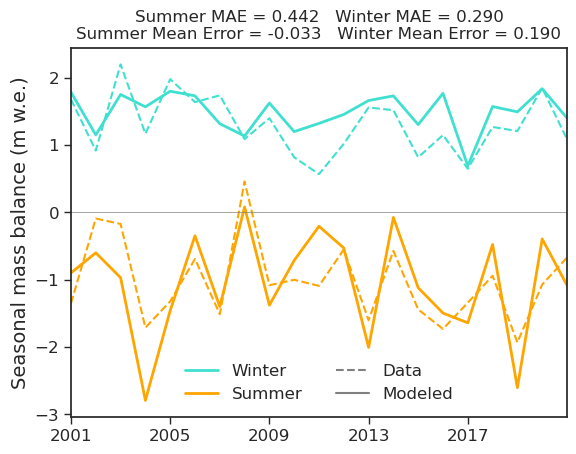

In [30]:
# ds = xr.open_dataset('/home/claire/research/Output/calibration/09_23/kw0.25_ksnowDouville_aice0.4_siteD_0.nc')
ds = xr.open_dataset('/home/claire/research/Output/calibration/10_01/kw_calibration_10_01_run39_0.nc')

# ds.melt.values *= 1000
# plot_by(ds,[startdate,'2022-04-20'],[['melt']],by='doy')
fig,ax = seasonal_mass_balance(data_fp,ds,'D',plot=True)
plt.show()